# Understanding the Fourier Transform by example
How to implement the Fast Fourier Transform algorithm in Python from scratch. <br />
@author: Simon J. Buehrer <br />
@date: 2021-02-04 <br /><br />
**Links:**
<ul>
<li> https://towardsdatascience.com/fast-fourier-transform-937926e591cb </li>
<li> https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/ </li>
<li> https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3 </li>
</ul> 

In [97]:
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
import datetime as dt 

import yfinance as yf #pip install yfinance /or pip3 /or conda
import numpy as np
import statsmodels.api as sm
from scipy.signal import find_peaks

# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 



## get data

In [98]:
#get current day and download hist. data 
today = dt.datetime.today().strftime('%Y-%m-%d')
hist = (dt.datetime.today()-dt.timedelta(5000)).strftime('%Y-%m-%d')

stockname='ABB'
print(today,hist)
stockdata_df = yf.download(stockname, start=hist, end=today)
print(stockdata_df.tail(5))

2021-02-05 2007-05-30
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-01-29  29.870001  29.920000  29.360001  29.510000  29.510000  2483700
2021-02-01  29.790001  30.160000  29.660000  30.139999  30.139999  1500400
2021-02-02  30.160000  30.520000  30.120001  30.469999  30.469999  1678900
2021-02-03  30.459999  30.639999  30.389999  30.559999  30.559999  1778900
2021-02-04  29.110001  29.129999  28.760000  29.020000  29.020000  4598100


## Calculating the difference (OLS)
und e neui column dezue tue wel datum müesam isch

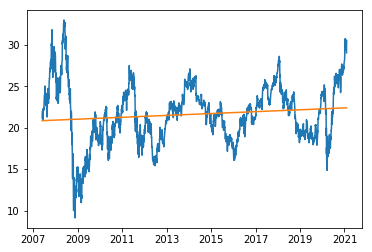

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     53.42
Date:                Fri, 05 Feb 2021   Prob (F-statistic):           3.33e-13
Time:                        13:16:02   Log-Likelihood:                -9304.4
No. Observations:                3448   AIC:                         1.861e+04
Df Residuals:                    3446   BIC:                         1.863e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8425      0.122    170.204      0.0

In [99]:
stockdata_df['row_num'] = np.arange(len(stockdata_df))
X = sm.add_constant(stockdata_df['row_num']) 
model = sm.OLS(stockdata_df['Close'], X).fit()
stockdata_df['OLS'] = model.predict(X) 

plt.plot(stockdata_df.index,stockdata_df['Close']) 
plt.plot(stockdata_df.index,stockdata_df['OLS'])
plt.show() 
print(model.summary())

stockdata_df['Diff']=stockdata_df['Close']-stockdata_df['OLS']

## es paar Diagramm
Afoch welis chan

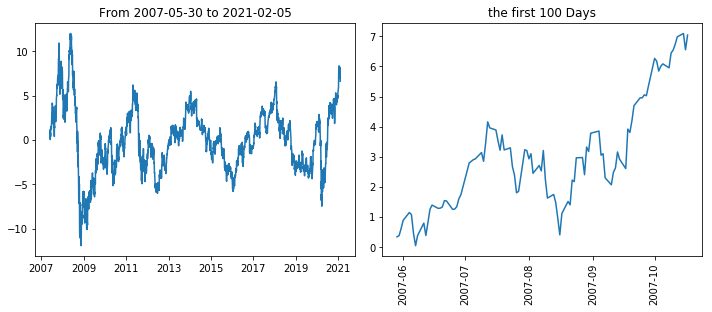

In [100]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index,stockdata_df['Diff']) 
ax1.set_title("From " + hist + " to " +today)

N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[:N],stockdata_df['Diff'][:N]) 
ax2.set_title("the first " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

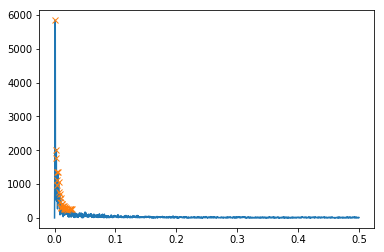

30


In [101]:
fft_output = np.fft.fft(stockdata_df['Diff'])
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(stockdata_df['Diff']))

# mask susch au negativi drinää
mask = freq >= 0
freq = freq[mask]
power = power[mask]

peaks, _ = find_peaks(power[freq >=0], height=200)

plt.plot(freq,power)
plt.plot(freq[peaks], power[peaks],'x')
plt.show() 
print(len(peaks))


In [102]:
output = pd.DataFrame()
output['index'] = peaks
output['freq'] = freq[peaks]
output['amplitude'] = power[peaks]
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

,index,freq,amplitude,fft
0,4,0.001160,5847.304902,5531.184429-1896.568858j
2,10,0.002900,2014.737975,448.341651+1964.219660j
1,8,0.002320,1778.426772,-1692.605547-545.791392j
6,19,0.005510,1362.174885,-1268.019002+497.642670j
3,12,0.003480,1357.637130,1285.029596+438.038257j
5,16,0.004640,1133.163000,-1101.844941+264.567780j
7,23,0.006671,1058.686138,742.269909+754.885236j
4,14,0.004060,984.159712,961.727754+208.925978j
8,26,0.007541,775.969989,775.756220+18.212954j
9,29,0.008411,710.944494,627.281801+334.603669j


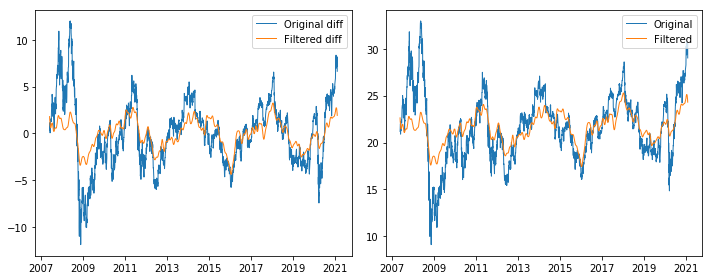

In [103]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_diff = np.fft.ifft(filtered_fft_output)

stockdata_df['Filtered']=stockdata_df['OLS']+filtered_diff

plt.figure(figsize=(10, 4))
ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original diff')
ax1.plot(stockdata_df.index, filtered_diff.real, linewidth=1, label='Filtered diff')
ax1.legend(loc='upper right')

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original')
ax2.plot(stockdata_df.index, stockdata_df['Filtered'], linewidth=1, label='Filtered')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [104]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq'] = output['freq']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq,amplitude,phase
label,,,,
FT_1,5531.184429-1896.568858j,0.001160,5847.304902,-0.330324
FT_2,448.341651+1964.219660j,0.002900,2014.737975,1.346387
FT_3,-1692.605547-545.791392j,0.002320,1778.426772,-2.829663
FT_4,-1268.019002+497.642670j,0.005510,1362.174885,2.767606
FT_5,1285.029596+438.038257j,0.003480,1357.637130,0.328525
FT_6,-1101.844941+264.567780j,0.004640,1133.163000,2.905940
FT_7,742.269909+754.885236j,0.006671,1058.686138,0.793824
FT_8,961.727754+208.925978j,0.004060,984.159712,0.213916
FT_9,775.756220+18.212954j,0.007541,775.969989,0.023473


In [105]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq'] = output['freq']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq,amplitude,phase
label,,,,
FT_1,5531.184429-1896.568858j,0.001160,5847.304902,-0.330324
FT_2,448.341651+1964.219660j,0.002900,2014.737975,1.346387
FT_3,-1692.605547-545.791392j,0.002320,1778.426772,-2.829663
FT_4,-1268.019002+497.642670j,0.005510,1362.174885,2.767606
FT_5,1285.029596+438.038257j,0.003480,1357.637130,0.328525
FT_6,-1101.844941+264.567780j,0.004640,1133.163000,2.905940
FT_7,742.269909+754.885236j,0.006671,1058.686138,0.793824
FT_8,961.727754+208.925978j,0.004060,984.159712,0.213916
FT_9,775.756220+18.212954j,0.007541,775.969989,0.023473
